# Remaining Useful Life

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as plb

from itertools import combinations

import warnings
import re

from utils import CLRS
import utils

params = {
    'axes.titlesize': 16, 
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12}

plb.rcParams.update(params)
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
sns.set_palette("muted")

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# Load Data

The data includes Run-to-Failure simulated data from NASA turbo fan jet engines intended for Asset Degrafation Modeling. <br> For this notebook the goal is to predict the remaining useful life (RUL) of each engine.

In particular, dataset FD001 contains time series of 21 sensors and 3 settings of 100 units(turbofan engine). Failure mode is High-Pressure Compressor.

The training data set has data up to the point of failure, therefore the maximum cycle for each engine was the life that was achieved by the engine. <br>
In the testing set, the data has not yet reached the point of failure, therefore the RUL file will tell us how much time still remained until failure. 


Data: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/

In [2]:
# Features
index_names = ['engine', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
col_names = index_names + setting_names + sensor_names

train_df = pd.read_csv(('CMaps/train_FD001.txt'), sep='\s+', header=None, names=col_names)
test_df = pd.read_csv(('CMaps/test_FD001.txt'), sep='\s+', header=None, names=col_names)
test_rul_df = pd.read_csv(('CMaps/RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

print(train_df.shape)
display(train_df.head(3))

print(test_df.shape)
display(test_df.head(3))

print(test_rul_df.shape)
display(test_rul_df.head(3))

(20631, 26)


,engine,cycle,setting_1,setting_2,setting_3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),(bypass-duct pressure) (psia),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(Engine pressure ratio(P50/P2),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Corrected core speed) (rpm),(Bypass Ratio),(Burner fuel-air ratio),(Bleed Enthalpy),(Required fan speed),(Required fan conversion speed),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow)
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442


(13096, 26)


,engine,cycle,setting_1,setting_2,setting_3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),(bypass-duct pressure) (psia),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(Engine pressure ratio(P50/P2),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Corrected core speed) (rpm),(Bypass Ratio),(Burner fuel-air ratio),(Bleed Enthalpy),(Required fan speed),(Required fan conversion speed),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow)
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.2,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.5,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.5,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166


(100, 1)


,RUL
0,112
1,98
2,69


In [3]:
# Combine train and test dfs for now so that they will be preprocessed together?
# train_df['dataset'] ='train'
# test_df['dataset'] ='test'
# df = pd.concat([train_df, test_df])

# Initial Preprocessing

- Remove columns with constant values
- Check and fix data types and remove duplicates
- Check and fix missing and unlikely values
- Sanity checks

Notes:
1. Make sure the data is ordered accordingly i.e. in increasing order of `['engine', 'cycle']`

#### Remove columns with constant values

They won't be helpful for the model

In [4]:
df_ = train_df.nunique()
display(df_)

drop_list = list(df_[df_==1].index)
print(len(drop_list), drop_list)

train_df = train_df.drop(drop_list, axis=1)
test_df = test_df.drop(drop_list, axis=1)
set(train_df.columns) & set(drop_list)

engine                                      100
cycle                                       362
setting_1                                   158
setting_2                                    13
setting_3                                     1
(Fan inlet temperature) (◦R)                  1
(LPC outlet temperature) (◦R)               310
(HPC outlet temperature) (◦R)              3012
(LPT outlet temperature) (◦R)              4051
(Fan inlet Pressure) (psia)                   1
(bypass-duct pressure) (psia)                 2
(HPC outlet pressure) (psia)                513
(Physical fan speed) (rpm)                   53
(Physical core speed) (rpm)                6403
(Engine pressure ratio(P50/P2)                1
(HPC outlet Static pressure) (psia)         159
(Ratio of fuel flow to Ps30) (pps/psia)     427
(Corrected fan speed) (rpm)                  56
(Corrected core speed) (rpm)               6078
(Bypass Ratio)                             1918
(Burner fuel-air ratio)                 

7 ['setting_3', '(Fan inlet temperature) (◦R)', '(Fan inlet Pressure) (psia)', '(Engine pressure ratio(P50/P2)', '(Burner fuel-air ratio)', '(Required fan speed)', '(Required fan conversion speed)']


set()

In [5]:
# Feature with two unique values, drop since very close
c = '(bypass-duct pressure) (psia)'
display(train_df[c].unique())
train_df = train_df.drop([c], axis=1)
test_df = test_df.drop([c], axis=1)

array([21.61, 21.6 ])

#### Check and fix data types and remove duplicates

In [6]:
# CHECK DATA TYPES
display(train_df.dtypes)

# CHECK DUPLICATES
print('No. of duplicated records across all columns: ', train_df.duplicated().sum())
train_df.drop_duplicates(inplace=True)

engine                                       int64
cycle                                        int64
setting_1                                  float64
setting_2                                  float64
(LPC outlet temperature) (◦R)              float64
(HPC outlet temperature) (◦R)              float64
(LPT outlet temperature) (◦R)              float64
(HPC outlet pressure) (psia)               float64
(Physical fan speed) (rpm)                 float64
(Physical core speed) (rpm)                float64
(HPC outlet Static pressure) (psia)        float64
(Ratio of fuel flow to Ps30) (pps/psia)    float64
(Corrected fan speed) (rpm)                float64
(Corrected core speed) (rpm)               float64
(Bypass Ratio)                             float64
(Bleed Enthalpy)                             int64
(High-pressure turbines Cool air flow)     float64
(Low-pressure turbines Cool air flow)      float64
dtype: object

No. of duplicated records across all columns:  0


#### Check for and fix missing and unlikely values

In [7]:
# CHECK FOR MISSING VALUES
def get_percent_null(df):
    x = df.isnull().sum()*100 / len(df)
    return display(x[x>0].to_frame('precent_nulls'))

get_percent_null(train_df)

na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', 
    '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NA', 'NULL', 
    'NaN', 'n/a', 'nan', 'null', 'None', 'none', 'na']

print('Check if there are other types of missing values:')
for x in na_values:
    df_ = (train_df == x).sum()
    if df_.sum() > 0:
        print(f'The ff column(s): {df_[df_ > 0].index.to_list()} contain(s) ', f'"{x}"') 

,precent_nulls


Check if there are other types of missing values:


In [8]:
# CHECK FOR UNLIKELY VALUES
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
engine,20631.0,51.506568,29.227633,1.0000,26.0000,52.0000,77.0000,100.0000
cycle,20631.0,108.807862,68.880990,1.0000,52.0000,104.0000,156.0000,362.0000
setting_1,20631.0,-0.000009,0.002187,-0.0087,-0.0015,0.0000,0.0015,0.0087
setting_2,20631.0,0.000002,0.000293,-0.0006,-0.0002,0.0000,0.0003,0.0006
(LPC outlet temperature) (◦R),20631.0,642.680934,0.500053,641.2100,642.3250,642.6400,643.0000,644.5300
(HPC outlet temperature) (◦R),20631.0,1590.523119,6.131150,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
(LPT outlet temperature) (◦R),20631.0,1408.933782,9.000605,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
(HPC outlet pressure) (psia),20631.0,553.367711,0.885092,549.8500,552.8100,553.4400,554.0100,556.0600
(Physical fan speed) (rpm),20631.0,2388.096652,0.070985,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
(Physical core speed) (rpm),20631.0,9065.242941,22.082880,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900


#### Others

In [9]:
# Drop uncorrected features?
print(np.corrcoef(train_df['(Physical fan speed) (rpm)'], train_df['(Corrected fan speed) (rpm)']))
print(np.corrcoef(train_df['(Physical core speed) (rpm)'], train_df['(Corrected core speed) (rpm)']))

train_df = train_df.drop(['(Physical fan speed) (rpm)', '(Physical core speed) (rpm)'], axis=1)
test_df = test_df.drop(['(Physical fan speed) (rpm)', '(Physical core speed) (rpm)'], axis=1)

[[1.         0.82608433]
 [0.82608433 1.        ]]
[[1.        0.9631566]
 [0.9631566 1.       ]]


In [10]:
# Check if there are RUL greater than max life? there is one, drop this engine
(train_df.groupby('engine').cycle.max() - test_rul_df.values.flatten()).sort_values()

engine
39    -14
65     25
57     34
74     40
70     43
     ... 
67    236
69    241
64    255
56    260
92    321
Name: cycle, Length: 100, dtype: int64

TODO: 
1. Understand the dataset. Is engine 39 invalid?
2. Test set is not thoroughly checked with similar tests as train set

In [11]:
# Add the RUL column to data

# Train
train_df = train_df.merge(
    train_df.groupby('engine').cycle.max().to_frame('lifespan'), 
    how='left', 
    on=['engine'])
train_df['RUL'] = train_df.lifespan - train_df.cycle

# Test
df_ = pd.DataFrame(test_df.groupby('engine').cycle.max().values \
            + test_rul_df.values.flatten(), columns=['lifespan'])
df_.index.name = 'engine'
test_df = test_df.merge(
    df_, 
    how='left', 
    on=['engine'])
test_df['RUL'] = test_df.lifespan - test_df.cycle

# TODO: Feature Engineering

1. Are there values that can be calculated using given features (using an established formula)
2. Polynomial Features?

# Exploratory Data Analysis

- A low pressure compressor (LPC) and high pressure compressor (HPC) supply compressed high temperature, high pressure gases to the combustor. 
- Low pressure turbine (LPT) can decelerate and pressurize air to improve the chemical energy conversion efficiency of aviation kerosene. 
- High pressure turbines (HPT) generate mechanical energy by using high temperature and high pressure gas strike turbine blades. 
- Low-pressure rotor (N1), high-pressure rotor (N2), and nozzle guarantee the combustion efficiency of the engine.

In [12]:
train_df.head(2)

,engine,cycle,setting_1,setting_2,(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(HPC outlet pressure) (psia),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Corrected core speed) (rpm),(Bypass Ratio),(Bleed Enthalpy),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),lifespan,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,192,190


In [13]:
# Separate/group columns
# TODO: separate NUM_COLS further into continuous and ordinal
c = train_df.dtypes == object

TARGET_COL = 'RUL'
NUM_COLS   = list(train_df.select_dtypes(include=np.number).columns)
CAT_COLS   = list(c[c].index)

NUM_COLS.remove(TARGET_COL)
NUM_COLS.remove('lifespan')

DROP_COLS_CANDIDATES = set()


print(len(NUM_COLS), len(CAT_COLS))

16 0


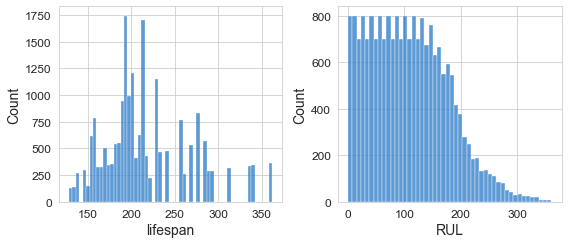

In [14]:
fig, axs = plt.subplots(1, 2, figsize=[8,3.5])

for i, c in enumerate(['lifespan', 'RUL']):
    sns.histplot(data=train_df, x=c, ax=axs[i], color=CLRS['lblue'])
plt.tight_layout()

In [15]:
train_df.lifespan.median()

207.0

## Relationships Among Numeric Features and Target Variable

### Correlation Among Features

,(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia)
(LPT outlet temperature) (◦R),0.83,-0.82
(HPC outlet pressure) (psia),-0.82,0.81
(HPC outlet Static pressure) (psia),NaN,-0.85


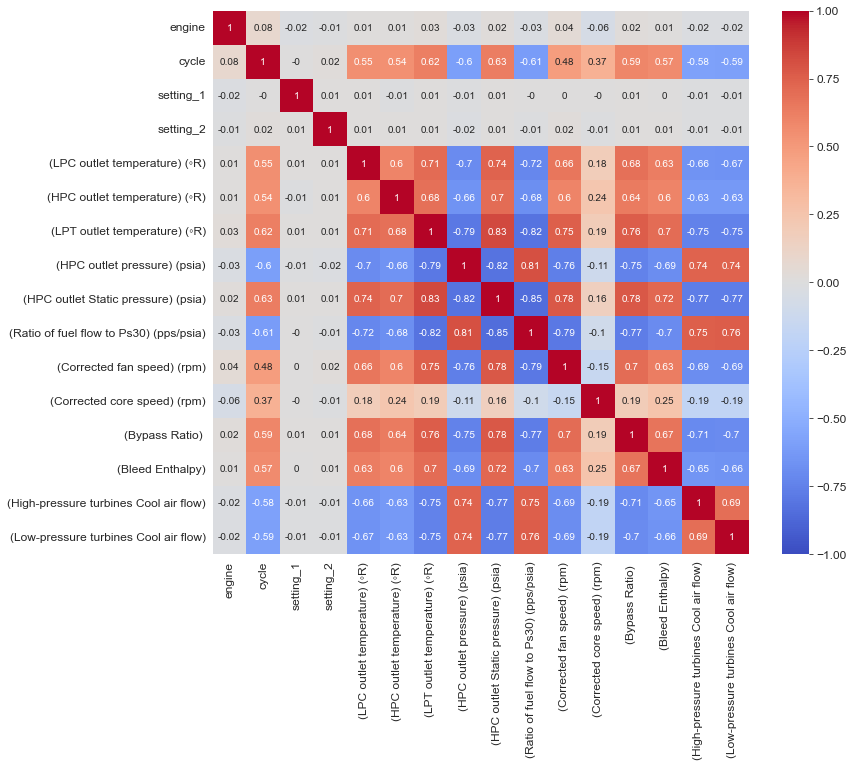

In [16]:
fig = plt.figure(figsize=(12,10))
df_ = train_df[NUM_COLS].corr(method='pearson').round(2)
ax = sns.heatmap(df_, annot=True, vmin=-1, vmax=1, cbar=True, cmap='coolwarm')

df_ = utils.get_trunc_corr_df(df_, 0.8)
df_

- There are highly collinear features. 
- Since we might be using models that allow multicollinearity, we won't be dropping any features at this point

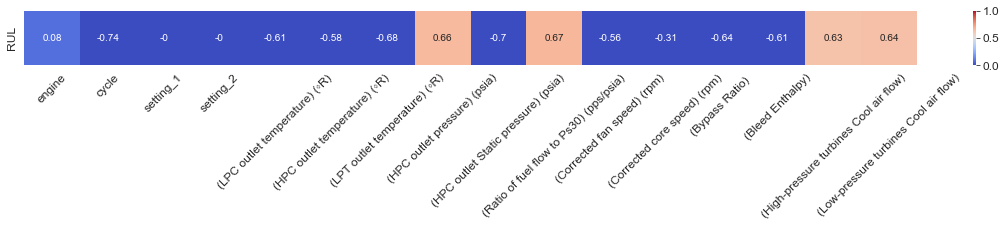

In [17]:
fig = plt.figure(figsize=(20,1))
df_ = train_df[NUM_COLS+[TARGET_COL]].corr(method='pearson').round(2)['RUL'].to_frame('RUL')[:-1].T
ax = sns.heatmap(
    df_, 
    vmin=0, vmax=1, annot=True, cbar=True, cmap='coolwarm')
x = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()


At 0.7 threshold, cycle is highly correlated with RUL and so we drop this column

In [18]:
# TODO: reconsider
NUM_COLS.remove('cycle')

### Distribution of Features

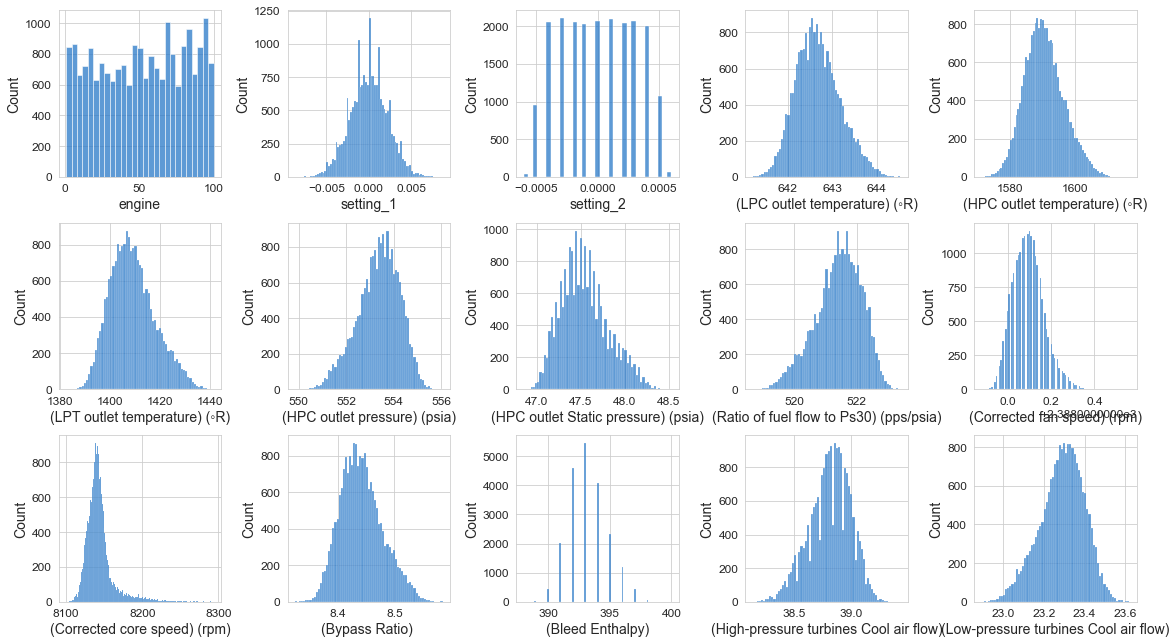

In [19]:
fig, axs = plt.subplots(3, 5, figsize=[16,9])
axs = axs.flatten()

for i, c in enumerate(NUM_COLS):
    sns.histplot(data=train_df, x=c, ax=axs[i], color=CLRS['lblue'])
plt.tight_layout()

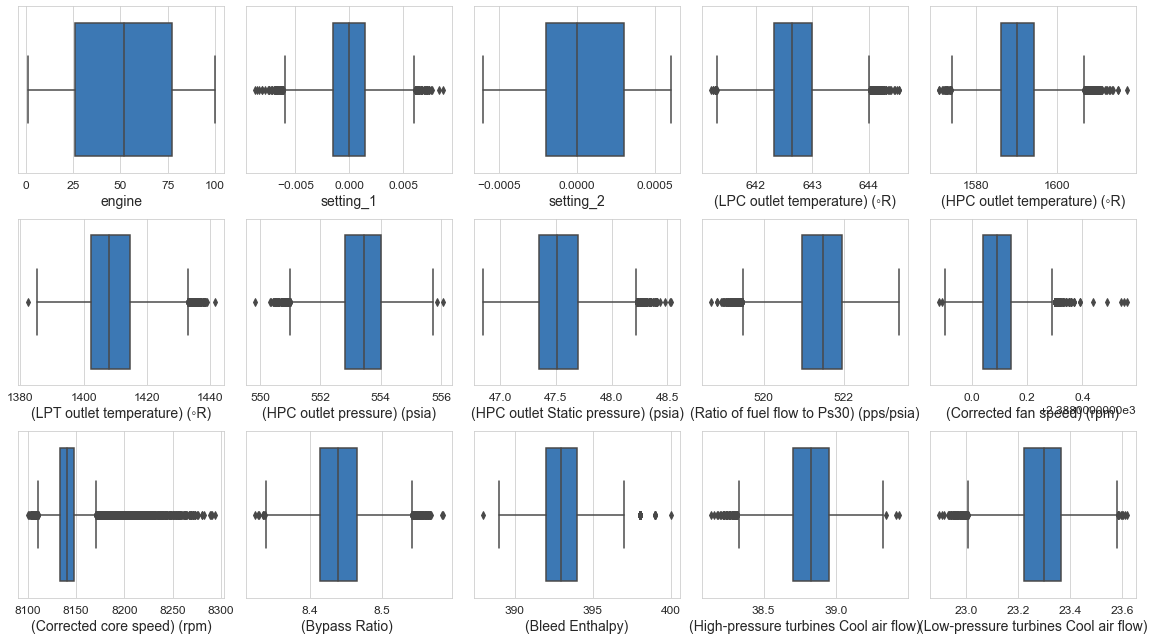

In [20]:
fig, axs = plt.subplots(3, 5, figsize=[16,9])
axs = axs.flatten()

for i, c in enumerate(NUM_COLS):
    sns.boxplot(data=train_df, x=c, ax=axs[i], color=CLRS['lblue'])
plt.tight_layout()

- It seems that many of the features exhibit a normal distribution
- Many of the features have outliers 

## Check Trends for the Features

- First50 engines only so it won't take a long time

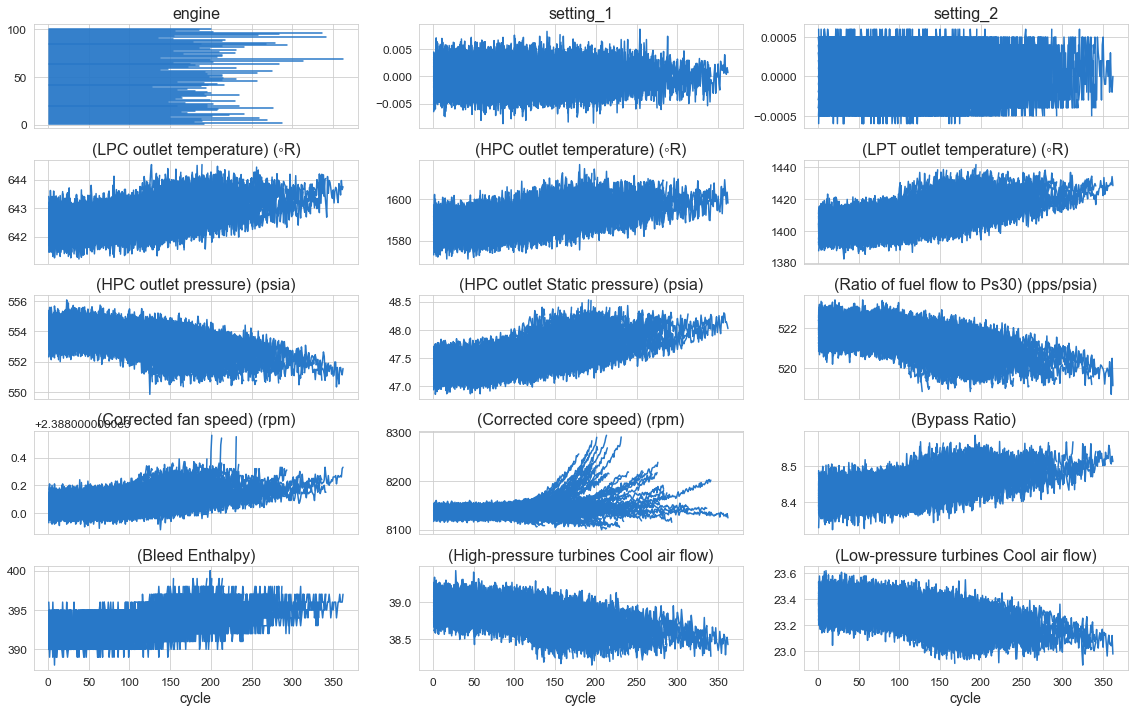

In [21]:
fig, axs = plt.subplots(5, 3, figsize=[16,10], sharex=True)
axs = axs.flatten()

for e in train_df.engine.unique():
    for i,c in enumerate(NUM_COLS):
        sns.lineplot(
            data=train_df[train_df['engine']==e], x='cycle', y=c, 
            color=CLRS['lblue'], ax=axs[i])
        # sns.scatterplot(
        #     data=train_df.query(f'RUL==0 and engine=={e}'), x='cycle', y=c, 
        #     marker='X', s=70, color=CLRS['red'], ax=axs[i])
        axs[i].set_ylabel('')
        axs[i].set_title(c)
plt.tight_layout()

- As expected, there are noticeable increasing and decreasing trend for the different features as the engines reach their failure point
    - Not true for corrected core fan speed. Values seems to be stable upto cycle 125 then goes to different trajectories before finally failing at varying speeds
- Since our data is low resolution i.e. one datapoints per cyle and not multiple datapoints per cycle, we will not try to smoothen the curves e.g. using moving average or filters

TODO:
- Plot where failure points are aligned
- Is clipping RUL a valid preprocessing steps? "will help in the prediction process as it reduces some overhead without affecting the main objective as 195 is already a high RUL"?????
- Misc. Plotting ideas
    - plot standard deviation, etc of each sensors across all engines
    - plot per engine e.g. std, or range from start to end of each sensor for each engine? are there angines that are more susceptible to failure? e.g. more increase in temperature

# Modeling - Traditional ML

In [22]:
import pickle

from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from catboost import CatBoostRegressor 
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance

import shap

In [23]:
# Idea: Store different sets of data (i.e. with different features and preprocessing steps in a dictionary)

In [24]:
train_df.head(2)

,engine,cycle,setting_1,setting_2,(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(HPC outlet pressure) (psia),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Corrected core speed) (rpm),(Bypass Ratio),(Bleed Enthalpy),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),lifespan,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,192,190


## Preprocess Data
1. Handle Outliers
2. Encode/Transform Data
3. Drop Highly Correlated Features
4. Scale data

NOTES:
1. Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like
2. If your data contains many outliers, scaling using the mean and variance of the data is likely to not work very well. In these cases, you can use RobustScaler as a drop-in replacement instead.
3. Do we need to or can we preprocess different features differently? E.g. MinMax Scaler for low STD feature.

In [25]:
# HANDLE OUTLIERS
OUTLR_COLS = NUM_COLS
rs_transform = RobustScaler()
train_df[OUTLR_COLS] = rs_transform.fit_transform(train_df[OUTLR_COLS])

# DROP HIGHLY CORRELATED FEATURES
#

# Z-SCORE NORMALIZE DATA
# train_df[NUM_COLS] = StandardScaler().fit_transform(train_df[NUM_COLS])

## Choose Baseline Model

1. Feature combinations to try: NUM_COLS + ['cycle],
2. ML Regressors to try: LinearRegression, CatBoostRegressor, XGBRegressor, RandomForestRegressor, SVR
3. Evalutaion metrics to try: mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

### Split Data into Train Set and Test Set
- 80-20 split

In [26]:
x_train, x_test, y_train, y_test = \
    train_test_split(
        train_df[NUM_COLS+['cycle']], train_df[TARGET_COL], test_size = 0.2, random_state = 100
                )

sum(y_test)/len(y_test), sum(y_train)/len(y_train)

(107.1194572328568, 107.98000484730974)

In [27]:
# OVER-SAMPLE AND UNDER-SAMPLE THE TRAIN SET
# According to the user guide, ENN tends to clean more noisy samples than Tomek
# smote_enn = SMOTEENN(random_state=42) 

# x_train, y_train = smote_enn.fit_resample(x_train, y_train)

### Train Baseline Models

In [28]:
# TODO: Add LightGBM Classifier

LR_reg  = LinearRegression()
CB_reg  = CatBoostRegressor(random_state = 100, verbose=False)
XGB_reg = XGBRegressor(random_state = 100)
RF_reg  = RandomForestRegressor(random_state = 100)
SVM_reg = SVR()


regressors  = {'LR_reg': LR_reg, 'CB_reg': CB_reg, 'CB_reg': CB_reg, 'RF_reg': RF_reg, 'SVM_reg': SVM_reg}
eval_metrics = {'mean_squared_error': mean_squared_error, 'r2_score': r2_score, 
                'mean_absolute_error': mean_absolute_error, 'mean_absolute_percentage_error': mean_absolute_percentage_error}
feature_sets = {'feat_set1': NUM_COLS+['cycle']}

print(len(feature_sets['feat_set1']))

16


In [29]:
clf_performance = {}

for featr_k, featr_v in feature_sets.items():
    x_train_ = x_train[featr_v]
    x_test_ = x_test[featr_v]

    clfs = {}
    for clf_k, clf_v in regressors.items():
        clf_v = clf_v.fit(x_train_, y_train)
        y_pred = clf_v.predict(x_test_)

        eval_scores = {}
        for metric_k, metric_v in eval_metrics.items():
            eval_scores.update({metric_k:metric_v(y_test, y_pred)})
        
        clfs.update({clf_k:eval_scores})

    clf_performance.update({featr_k:clfs})

del x_train_, x_test_, clfs, eval_scores  

### Evaluate Models and Choose Final Model(s)

TODO: 
- Should baseline model be chosen based on training performance or test or both? Are there metrics to consider both?


In [30]:
perf_df = pd.DataFrame.from_dict(
    {(i,j): clf_performance[i][j] 
        for i in clf_performance.keys() 
        for j in clf_performance[i].keys()},
    orient='columns').round(5)
perf_df

feat_set1                              \
                                      LR_reg        CB_reg        RF_reg   
mean_squared_error              1.480743e+03  4.379222e+01  2.367507e+02   
r2_score                        6.823200e-01  9.906000e-01  9.492100e-01   
mean_absolute_error             2.975743e+01  5.061720e+00  1.045748e+01   
mean_absolute_percentage_error  8.680490e+14  7.689552e+13  9.130511e+13   

                                              
                                     SVM_reg  
mean_squared_error              1.898374e+03  
r2_score                        5.927200e-01  
mean_absolute_error             3.130971e+01  
mean_absolute_percentage_error  7.722449e+14

- The best performing base model is CatBoost (3/4 metrics)

## Final Model

- Feature selection 
    - recursive feature elimination (RFE)
    - TODO: Try other [methods](https://scikit-learn.org/stable/modules/feature_selection.html)
- GridSeachCV (hyperparameter tuning + cross validation)

### Feature Selection

In [31]:
feature_set = 'feat_set1'
final_model = CB_reg

rfecv = RFECV(
    estimator=final_model,
    step=1,
    cv=5,
    # scoring=rsme,
    min_features_to_select=1,
)
rfecv.fit(x_train, y_train)

print(f'Optimal number of features:{rfecv.n_features_}')

# Columns to drop
drop_cols = [feature_sets[feature_set][i] for i,j in enumerate(rfecv.ranking_ != 1) if j]
print(drop_cols)

if not drop_cols:
    x_train.drop(drop_cols, axis=1, inplace=True)
    x_test.drop(drop_cols, axis=1, inplace=True)
    NUM_COLS = [x for x in NUM_COLS if x not in drop_cols]

Optimal number of features:2
['setting_1', 'setting_2', '(LPC outlet temperature) (◦R)', '(HPC outlet temperature) (◦R)', '(LPT outlet temperature) (◦R)', '(HPC outlet pressure) (psia)', '(HPC outlet Static pressure) (psia)', '(Ratio of fuel flow to Ps30) (pps/psia)', '(Corrected fan speed) (rpm)', '(Corrected core speed) (rpm)', '(Bypass Ratio) ', '(Bleed Enthalpy)', '(High-pressure turbines Cool air flow)', '(Low-pressure turbines Cool air flow)']


### Hyperparameter Tuning

In [32]:
# GridSearchCV

CB_param_grid = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.05, 0.10, 0.15],
    'max_depth': [4, 6, 8]}

param_grids = {'CB_reg':CB_param_grid}
base_models = ['CB_reg']
scoring = ['neg_mean_squared_error',  'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']

# TODO: Try multiple metrics during grid search
def gscv_helper(X, y, model, param_grid, **kwargs):
    gscv = GridSearchCV(
        estimator=model, 
        param_grid=param_grid,
        scoring=scoring,
        refit='neg_mean_squared_error',
        return_train_score=True)
    return gscv.fit(X, y)

In [33]:
perf_gscv_df = {}
modl_gscv_df = {}
for k in base_models:
    m = gscv_helper(x_train, y_train, regressors[k], param_grids[k])
    y = m.predict(x_test)

    eval_scores = {}
    for metric_k, metric_v in eval_metrics.items():
        eval_scores.update({metric_k:round(metric_v(y_test, y),3)})

    perf_gscv_df.update({k:eval_scores})
    modl_gscv_df.update({k:[m,y]})

In [34]:
# Tuned nmodels performance
tuned_perf_df = pd.DataFrame.from_dict(
    {(i): perf_gscv_df[i] for i in perf_gscv_df.keys()}, 
    orient='index').T
tuned_perf_df

,CB_reg
mean_squared_error,4.224000e+01
r2_score,9.910000e-01
mean_absolute_error,4.913000e+00
mean_absolute_percentage_error,6.478816e+13


In [35]:
# Base models performance
perf_df['feat_set1'][base_models]

,CB_reg
mean_squared_error,4.379222e+01
r2_score,9.906000e-01
mean_absolute_error,5.061720e+00
mean_absolute_percentage_error,7.689552e+13


- The model did not improve
- TODO: Stud hyperparameters of CatBoost and XGBoost

## Evaluate/ Validate Model/ Check Scalability

### Plot train vs test performance

- no overfitting
- TODO: Do more in terms of checking if model overfitted e.g. check bias and variance of the model?

In [36]:
gscv_res = modl_gscv_df['CB_reg'][0]
final_model = gscv_res.best_estimator_
y_pred = modl_gscv_df['CB_reg'][1]
gscv_res.best_params_

{'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 400}

In [37]:
tuned_perf_df.CB_reg.to_dict()

{'mean_squared_error': 42.24,
 'r2_score': 0.991,
 'mean_absolute_error': 4.913,
 'mean_absolute_percentage_error': 64788162761402.61}

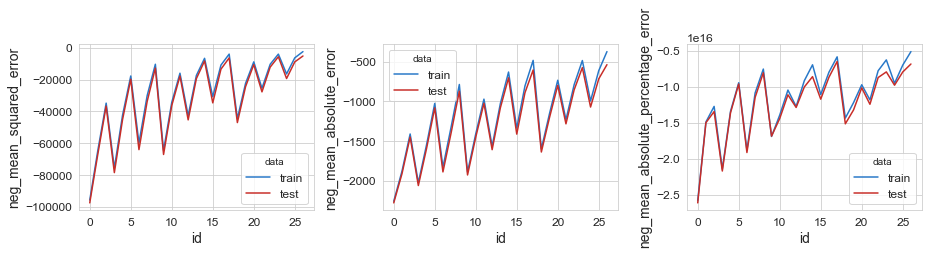

In [38]:
res = gscv_res.cv_results_

dfs = []
for s in scoring:
    t1 = f'mean_train_{s}'
    t2 = f'mean_test_{s}'
    t3 = ['train','test']
    df_ = pd.DataFrame([res[t1], res[t2]], index=t3).T * 100
    df_ = pd.melt(df_, var_name='data', value_name=s, value_vars=t3, ignore_index=False)
    dfs.append(df_.set_index('data', append=True))

df_ = pd.concat(dfs, axis=1).reset_index().rename(columns={'level_0':'id'}) 

fig, axs = plt.subplots(1, len(scoring), figsize=(13,3.25))
for i,s in enumerate(scoring):
    sns.lineplot(
        x='id', y=s, hue='data', data=df_, ax=axs[i], 
        palette=[CLRS['lblue'],CLRS['red']])

plt.tight_layout()

- TODO: Check why values are very high for negative version of eval metrics

### Feature Importance

TODO: 
- Do more feature importance, e.g. check p-value of the features (?), Handle featuer importance properly when there are [highly correlated features](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py)

#### Built-in Feature Importance

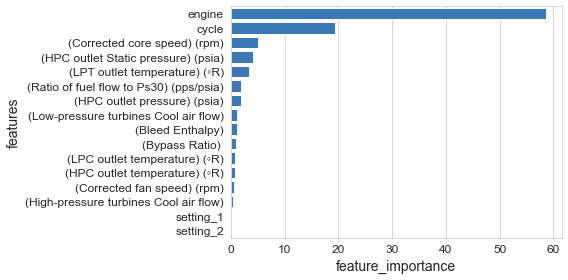

In [39]:
# XGBoost has no built-in feature importance for 'gbtree' booster
df_ = pd.DataFrame(
    final_model.get_feature_importance(), 
    columns=['feature_importance'], 
    index = x_train.columns) \
        .sort_values(by=['feature_importance'], ascending=False)
df_.index.name = 'features'
df_.reset_index(inplace=True)

plt.figure(figsize=(8, 4))
sns.barplot(y=df_['features'], x=df_['feature_importance'], orient='h', color=CLRS['lblue'])
plt.tight_layout()

#### Permutation-based

- TODO: Study how this works and how to interpret results

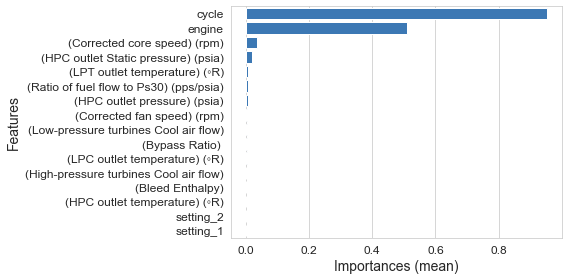

In [40]:
pi = permutation_importance(final_model, x_test, y_test, random_state=100)
pi = pd.DataFrame(
    [x_train.columns, pi['importances_mean']], 
    index=['Features', 'Importances (mean)']) \
        .T.sort_values('Importances (mean)', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(y=pi['Features'], x=pi['Importances (mean)'], orient='h', color=CLRS['lblue'])
plt.tight_layout()

#### SHAP-based

- TODO: Study SHAP, how it works and how to interpret results

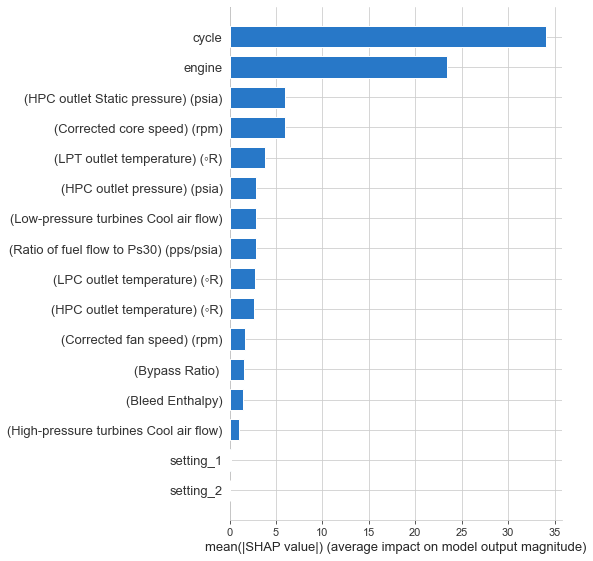

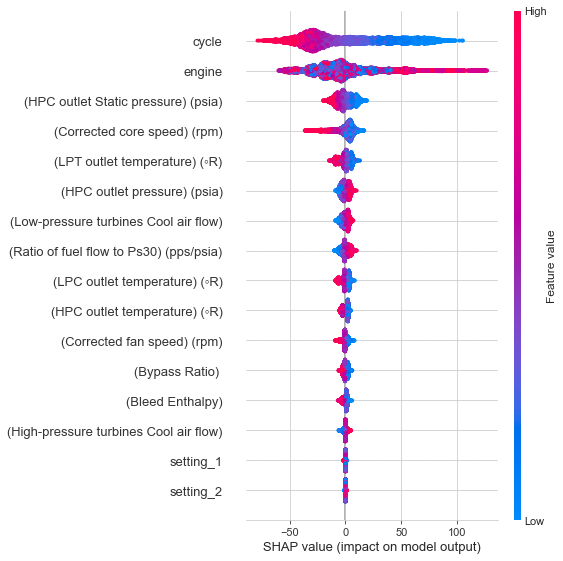

In [41]:
explainer = shap.TreeExplainer(final_model, random_state=100)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar", color=CLRS['lblue'])
shap.summary_plot(shap_values, x_train)

# TODO: make visual evaluation of cross validated predictions
1. Actual vs Predicted
2. Residuals vs Predicted


# TODO: when to use test_df provided
# RUL test is 100 values only!! Review kaggle again https://www.kaggle.com/code/carlkirstein/predictive-maintenance-nasa-turbofan-regression


# Check cycles in train vs test, is test a subset of train? how to properly test? are engines in test different from engines in train?
# TODO: Why is engine the most important feature? maybe in actual modeling to check which measurement/feature is really important, remove engine and cycle

In [42]:
# sns.lineplot(x = np.arange(0,train_df.engine.nunique()),
#                 y=y_test,
#                 color=CLRS['lblue'],
#                 label = 'actual')

# sns.lineplot(x = np.arange(0,train_df.engine.nunique()),
#                 y=y_pred,
#                 color=CLRS['lred'],
#                 label = 'predictions')

### Model Scalability

- Scalability of the models in terms of computational cost e.g. training and scoring times.

In [43]:
gscv_res.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_neg_mean_squared_error', 'split1_test_neg_mean_squared_error', 'split2_test_neg_mean_squared_error', 'split3_test_neg_mean_squared_error', 'split4_test_neg_mean_squared_error', 'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 'rank_test_neg_mean_squared_error', 'split0_train_neg_mean_squared_error', 'split1_train_neg_mean_squared_error', 'split2_train_neg_mean_squared_error', 'split3_train_neg_mean_squared_error', 'split4_train_neg_mean_squared_error', 'mean_train_neg_mean_squared_error', 'std_train_neg_mean_squared_error', 'split0_test_neg_mean_absolute_error', 'split1_test_neg_mean_absolute_error', 'split2_test_neg_mean_absolute_error', 'split3_test_neg_mean_absolute_error', 'split4_test_neg_mean_absolute_error', 'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error', 'rank_test_n

In [44]:
l = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time']
for i in l:
    print(i, round(gscv_res.cv_results_[i][gscv_res.best_index_], 5), sep=':')

mean_fit_time:3.86898
std_fit_time:0.08166
mean_score_time:0.0038
std_score_time:0.0004


## Save model

In [45]:
with open('CB_final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

## Key Takeaways, Recommendations and Next Steps

- Trying different models, we found out that CatBoost performs best <br>
with the following metric scores during final modelling: 

        ```
        {'mean_squared_error': 589.419,
        'r2_score': 0.874,
        'mean_absolute_error': 17.875,
        'mean_absolute_percentage_error': 127078631502433.12}
        ```
Next Steps:
- Benchmark model
- Adjust probability probability threshold to let the business decide what works best

# OPTIONAL: Modeling - Deep Learning

In [46]:
# Do feature selection, backward regression????
# choose most common evaluation metrics
# Add cycle back if performance is low. In reality cycle is realy a useful feature
# Feature scaling, put note when to use which
# Feature engineering: adding historical data (for non squence modells)
    # rolling features e.g. rolling mean, difference with previous reading etc, do literature search
# NOTES: turning this into classification model e.g. bin RUL into no risk, low, medium, high
# Next steps: use all data which has other failure modes and combination of them? how to approach? Put this in TODOs
# TODO: do we need to create a model per engine? do we include engine as feature to encapsulate potential differences among engines? do we include cycle number?

In [47]:
# check data to know which method to use similarity model? survival? degredation? Put notes on this then explain why one is chosen over the others

In [48]:
# TODO: Include how can this be valuable!!!
# Plot True RUL vs Predicted RUL
# Check if sequence model is generally better, try using LSTM Trax transformer, or prophet, pretrained models (search in hugging face for sensors data)